In [1]:
import numpy as np
import sklearn.linear_model as sklm
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set(font_scale=1.6)
import sklearn.neural_network as sknn
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler

Implement a very simple point-estimate photo-z using sklearn's neural_network package.  Have two sets of mock LSST data, trim it to i < 25.3, train the net on a training set, then run on a test set and see how we do

In [3]:
def calculate_IQR_sigma(truez,pz):
    ez = (truez-pz)/(1.+truez)
    x75,x25 = np.percentile(ez,[75.,25.])
    iqrsig = (x75-x25)/1.349
    return iqrsig

def calculate_bias(truez,pz):
    ez = (truez-pz)/(1.+truez)
    return np.median(ez)
    

class LSST_data(object):
    def __init__(self):
        """
        Read in the LSST training and test data from predefined files listed below
        trim the data to i<25.3 and store
        """
        trainfile = "Final_Buzzard_training_file_scatmags.out"
        traindata = np.loadtxt(trainfile,usecols = (5,7,9,11,13,15,17))
        trainmags = traindata[:,1:]
        trainzs = traindata[:,0]
        mask = (trainmags[:,3]<25.3)
        cutmags = trainmags[mask]
        cutzs = trainzs[mask]
        cutcolors = cutmags[:,:-1] - cutmags[:,1:]
        self.trainzs = cutzs
        self.traincolors = cutcolors
        #save separate dataset with colors plus i-mag
        self.traincolorsplusmag = np.hstack([cutcolors,np.reshape(cutmags[:,3],(len(cutmags[:,3]),1))])
    
        
        testfile =  "1pct_Final_Buzzard_truthfile_scatmags.out"
        testdata = np.loadtxt(testfile,usecols = (5,7,9,11,13,15,17))
        testmags = testdata[:,1:]
        testzs = testdata[:,0]
        mask = (testmags[:,3]<25.3)
        cutmags = testmags[mask]
        self.testzs = testzs[mask]
        cutcolors = cutmags[:,:-1] - cutmags[:,1:]
        self.testcolors = cutcolors
        self.testcolorsplusmag = np.hstack([cutcolors,np.reshape(cutmags[:,3],(len(cutmags[:,3]),1))])


        
    def RegularizeData(self):
        scaler = StandardScaler()
        scaler.fit(self.traincolors)
        self.regtraincolors = scaler.transform(self.traincolors)
        scaler.fit(self.testcolors)
        self.regtestcolors = scaler.transform(self.testcolors)
        scaler.fit(self.traincolorsplusmag)
        self.regtraincolorsplusmag= scaler.transform(self.traincolorsplusmag)
        scaler.fit(self.testcolorsplusmag)
        self.regtestcolorsplusmag = scaler.transform(self.testcolorsplusmag)
        

In [4]:
lsstobj = LSST_data()
lsstobj.RegularizeData()

Let's make a few plots to visualize the data

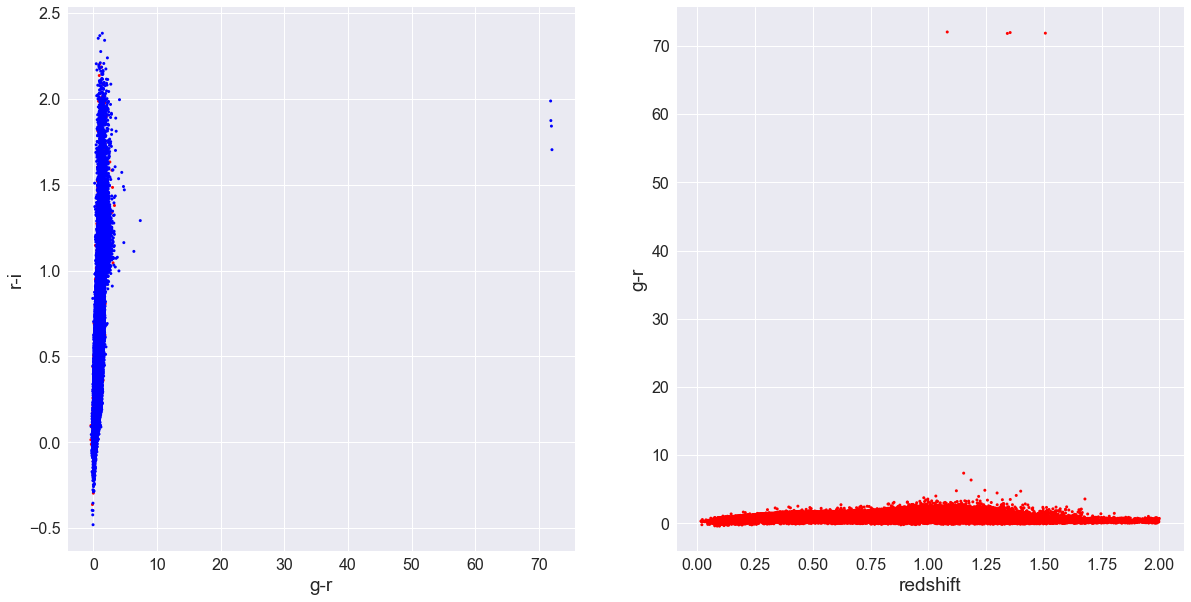

In [43]:
fig = plt.figure(figsize=(20,10))
ax=plt.subplot(121)
ax.scatter(lsstobj.testcolors[:,1],lsstobj.testcolors[:,2],s=9,c='r',edgecolor='none',label="test data")
ax.scatter(lsstobj.traincolors[:,1],lsstobj.traincolors[:,2],s=9,c='b',edgecolor='none',label="training data")
plt.xlabel("g-r",fontsize=19)
plt.ylabel("r-i",fontsize=19)
bx = plt.subplot(122)
bx.scatter(lsstobj.testzs,lsstobj.testcolors[:,1],s=9,c='r',edgecolor='none',label='test data')
bx.scatter(lsstobj.trainzs,lsstobj.traincolors[:,1],s=9,c='r',edgecolor='none',label='test data')
plt.xlabel("redshift",fontsize=19)
plt.ylabel("g-r",fontsize=19)


A couple outlier points because of mag = 99, let's ignore those and zoom in on the proper areas

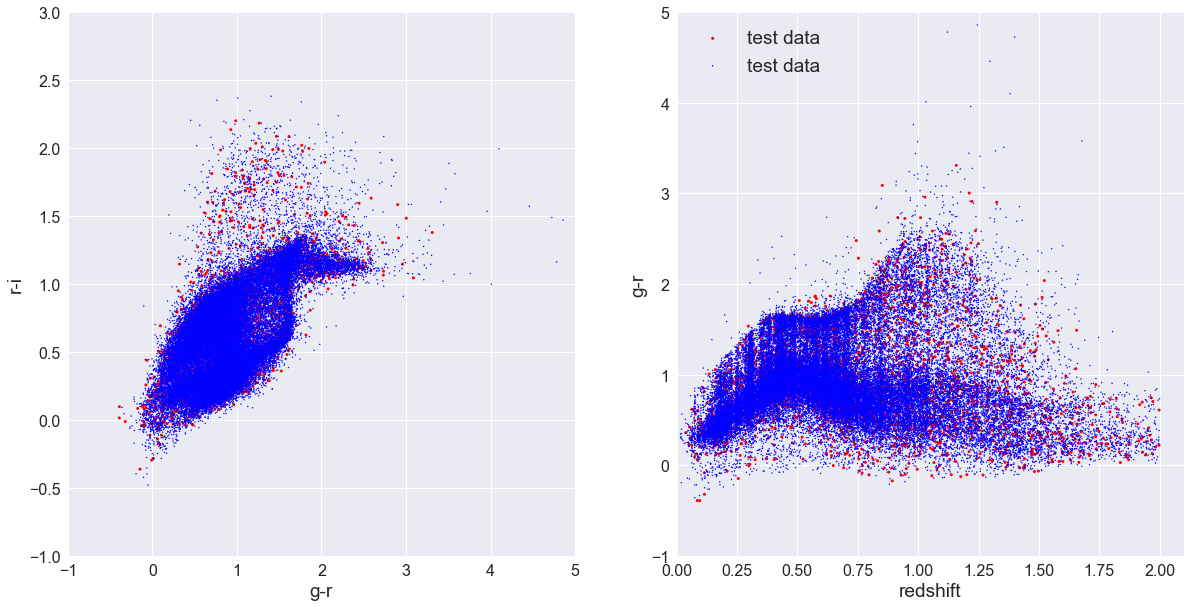

In [49]:
fig = plt.figure(figsize=(20,10))
ax=plt.subplot(121)
ax.scatter(lsstobj.testcolors[:,1],lsstobj.testcolors[:,2],s=9,c='r',edgecolor='none',label="test data")
ax.scatter(lsstobj.traincolors[:,1],lsstobj.traincolors[:,2],s=2,c='b',edgecolor='none',label="training data")
plt.xlabel("g-r",fontsize=19)
plt.ylabel("r-i",fontsize=19)
plt.xlim([-1,5])
plt.ylim([-1,3])
bx = plt.subplot(122)
bx.scatter(lsstobj.testzs,lsstobj.testcolors[:,1],s=9,c='r',edgecolor='none',label='test data')
bx.scatter(lsstobj.trainzs,lsstobj.traincolors[:,1],s=2,c='b',edgecolor='none',label='test data')
plt.xlabel("redshift",fontsize=19)
plt.ylabel("g-r",fontsize=19)
plt.xlim([0.,2.1])
plt.ylim([-1,5])
plt.legend(loc='upper left', fontsize=19)

The test data is drawn from the exact same distribution as the training data, so the NN should do a good job in predicting the values.  Our only concern may be the mag =99 values!

create an sklearn NN object, train it with the regularized colors used to predict the training set spec-z's.  Use a setup with 2 hidden layers and double the number of colors, so a 5:10:10:1 configuration for the neural net

In [5]:
lsstnn = sknn.MLPRegressor(hidden_layer_sizes=(10,10),activation='tanh',solver='lbfgs')

In [6]:
lsstnn.fit(lsstobj.regtraincolors,lsstobj.trainzs)

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [7]:
testcolorpz = lsstnn.predict(lsstobj.regtestcolors)

In [8]:
color_sig = calculate_IQR_sigma(lsstobj.testzs,testcolorpz)
print color_sig
color_bias = calculate_bias(lsstobj.testzs,testcolorpz)
print color_bias

0.0546848188774
0.00289749059205


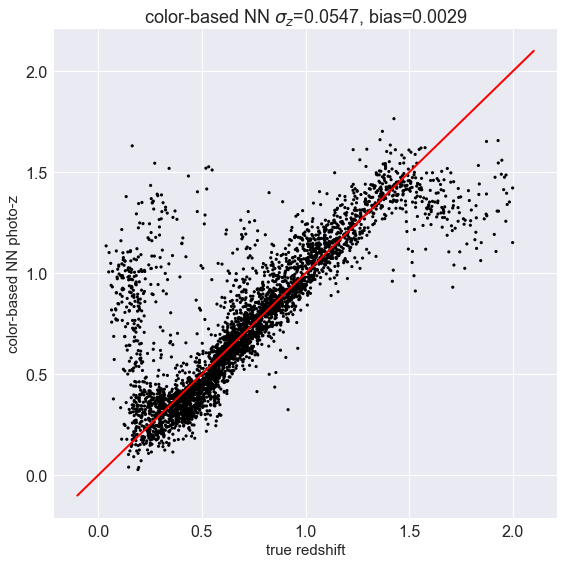

In [9]:
fig = plt.figure(figsize=(9,9))
plt.scatter(lsstobj.testzs,testcolorpz,s=10,c='k',edgecolor='none')
plt.plot([-.1,2.1],[-.1,2.1],c='r',lw=2)
plt.xlabel("true redshift",fontsize=15)
plt.ylabel("color-based NN photo-z",fontsize=15)
titletext = "color-based NN $\sigma_{z}$=%.4f, bias=%.4f"%(color_sig,color_bias)
plt.title(titletext,fontsize=18)

That looks ok, but let's try adding the magnitude as well, since galaxy magnitude should carry extra information.  Change the NN to have a 6:12:12:1 configuration

In [10]:
lsstnn2 = sknn.MLPRegressor(hidden_layer_sizes=(12,12),activation='tanh',solver='lbfgs')

In [11]:
lsstnn2.fit(lsstobj.regtraincolorsplusmag,lsstobj.trainzs)

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(12, 12), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [12]:
testcolormagpz = lsstnn2.predict(lsstobj.regtestcolorsplusmag)

In [13]:
colormag_sig = calculate_IQR_sigma(lsstobj.testzs,testcolormagpz)
print colormag_sig
colormag_bias = calculate_bias(lsstobj.testzs,testcolormagpz)
print colormag_bias

0.057687451061
0.00206747785259


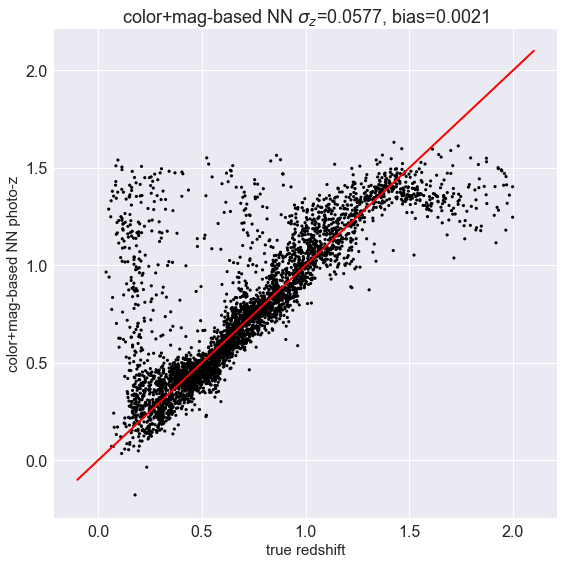

In [14]:
fig = plt.figure(figsize=(9,9))
plt.scatter(lsstobj.testzs,testcolormagpz,s=10,c='k',edgecolor='none')
plt.plot([-.1,2.1],[-.1,2.1],c='r',lw=2)
plt.xlabel("true redshift",fontsize=15)
plt.ylabel("color+mag-based NN photo-z",fontsize=15)
titletext = "color+mag-based NN $\sigma_{z}$=%.4f, bias=%.4f"%(colormag_sig,colormag_bias)
plt.title(titletext,fontsize=18)

It does slightly worse, but not by much (note that rerunning can switch results around, it is fairly unstable in this configuration, I'm guessing due to some random number generation during training)

Now check: did the regularization really do anything?  Let's try a run with no regularization and see how it compares

In [15]:
noregnn = sknn.MLPRegressor(hidden_layer_sizes=(10,10),activation='tanh',solver='lbfgs')

In [16]:
noregnn.fit(lsstobj.traincolors,lsstobj.trainzs)

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [17]:
noregpz = noregnn.predict(lsstobj.testcolors)

In [18]:
noreg_sig = calculate_IQR_sigma(lsstobj.testzs,noregpz)
print noreg_sig
noreg_bias = calculate_bias(lsstobj.testzs,noregpz)
print noreg_bias

0.055845353559
-0.00622117865371


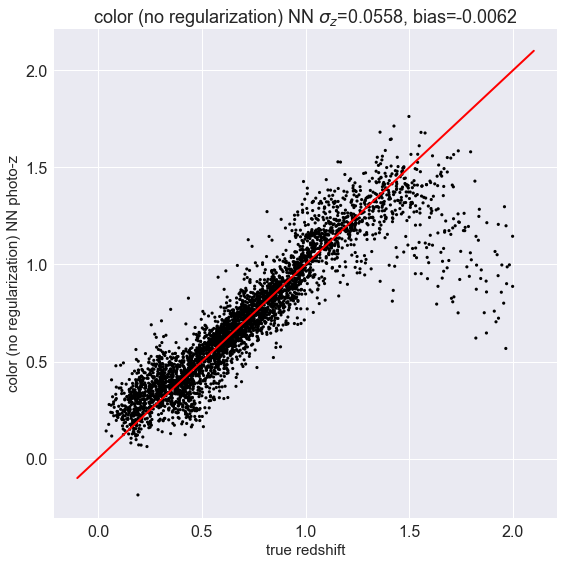

In [19]:
fig = plt.figure(figsize=(9,9))
plt.scatter(lsstobj.testzs,noregpz,s=10,c='k',edgecolor='none')
plt.plot([-.1,2.1],[-.1,2.1],c='r',lw=2)
plt.xlabel("true redshift",fontsize=15)
plt.ylabel("color (no regularization) NN photo-z",fontsize=15)
titletext = "color (no regularization) NN $\sigma_{z}$=%.4f, bias=%.4f"%(noreg_sig,noreg_bias)
plt.title(titletext,fontsize=18)

Regularization did some funny stuff at low redshift, and it's not much better, may be better to do without regularization

In [20]:
noregnn2 = sknn.MLPRegressor(hidden_layer_sizes=(12,12),activation='tanh',solver='lbfgs')

In [21]:
noregnn2.fit(lsstobj.traincolorsplusmag,lsstobj.trainzs)

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(12, 12), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [22]:
noregpz2 = noregnn2.predict(lsstobj.testcolorsplusmag)

In [23]:
noreg2_sig = calculate_IQR_sigma(lsstobj.testzs,noregpz2)
print noreg2_sig
noreg2_bias = calculate_bias(lsstobj.testzs,noregpz2)
print noreg2_bias

0.0789678757812
-0.00268782632288


In [24]:
noreg2_sig = calculate_IQR_sigma(lsstobj.testzs,noregpz2)
print noreg2_sig
noreg2_bias = calculate_bias(lsstobj.testzs,noregpz2)
print noreg2_bias

0.0789678757812
-0.00268782632288


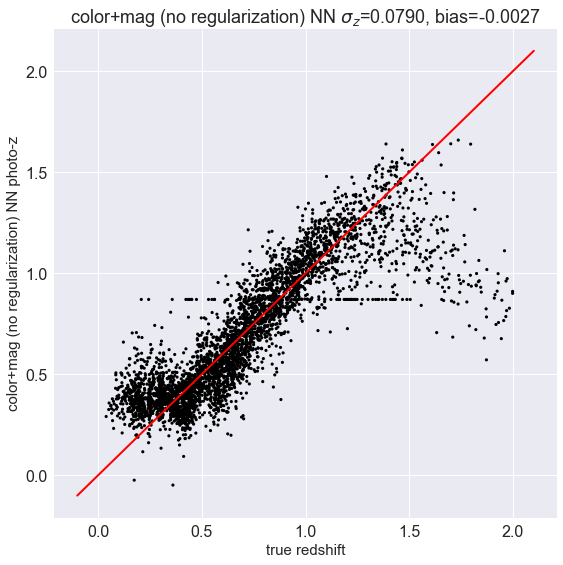

In [25]:
fig = plt.figure(figsize=(9,9))
plt.scatter(lsstobj.testzs,noregpz2,s=10,c='k',edgecolor='none')
plt.plot([-.1,2.1],[-.1,2.1],c='r',lw=2)
plt.xlabel("true redshift",fontsize=15)
plt.ylabel("color+mag (no regularization) NN photo-z",fontsize=15)
titletext = "color+mag (no regularization) NN $\sigma_{z}$=%.4f, bias=%.4f"%(noreg2_sig,noreg2_bias)
plt.title(titletext,fontsize=18)

Regularization did help in both cases

Now, let's compare the regularized color+mag to a simple linear regression

In [26]:
linreg = sklm.LinearRegression(fit_intercept=True,normalize=False)

In [27]:
linreg.fit(lsstobj.regtraincolorsplusmag,lsstobj.trainzs)

/Users/sam/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

look at the intercept and coefficients

In [28]:
print linreg.intercept_
print linreg.coef_

0.699486668273
[-0.02610349 -0.07087244  0.03707089  0.16249149  0.13070903  0.09778833]


This is telling us that the photo-z estimate is:
linreg_pz = 0.699 - 0.026*(u-g)  - 0.071*(g-r) + 0.037*(r-i) + 0.162*(i-z) + 0.131*(z-y) + 0.0978*imag (where all colors and mags have been regularized, so you would have to undo that regularization to figure out the actual coefficients)

In [29]:
linreg_pzs = linreg.predict(lsstobj.regtestcolorsplusmag)

In [30]:
linreg_sig = calculate_IQR_sigma(lsstobj.testzs,linreg_pzs)
print linreg_sig
linreg_bias = calculate_bias(lsstobj.testzs,linreg_pzs)
print linreg_bias

0.0994931581655
-0.00253297166547


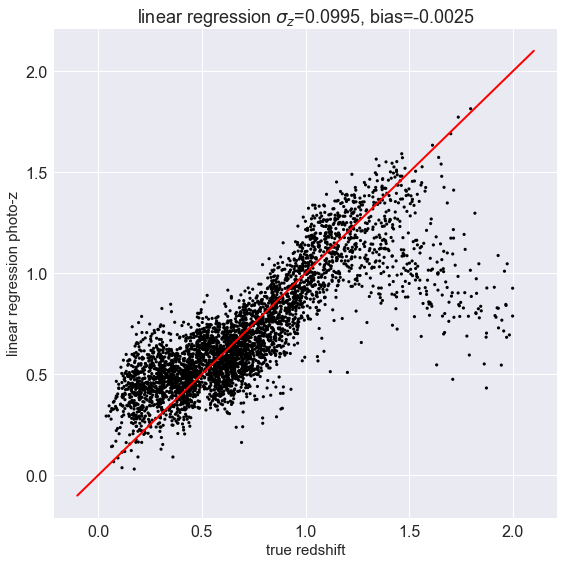

In [31]:
fig = plt.figure(figsize=(9,9))
plt.scatter(lsstobj.testzs,linreg_pzs,s=10,c='k',edgecolor='none')
plt.plot([-.1,2.1],[-.1,2.1],c='r',lw=2)
plt.xlabel("true redshift",fontsize=15)
plt.ylabel("linear regression photo-z",fontsize=15)
titletext = "linear regression $\sigma_{z}$=%.4f, bias=%.4f"%(linreg_sig,linreg_bias)
plt.title(titletext,fontsize=18)

Linear regression is much worse, as expected.

Note: I've ignored the magnitude and color errors here, weighting by errors may help results here

And for comparison, ANNz2 on this same data gets a sigma of 0.0244, so you can definitely do a lot better if you are careful!

Finally, let's do the linear regression with no regularization

In [32]:
linreg2 = sklm.LinearRegression(fit_intercept=True,normalize=False)

In [33]:
linreg2.fit(lsstobj.traincolorsplusmag,lsstobj.trainzs)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [34]:
print linreg2.intercept_
print linreg2.coef_

-1.35314399067
[-0.00257682 -0.08543408  0.10142213  0.63709544  0.52126685  0.07236509]


So, linreg2_pz = -1.353 -0.0026*(u-g) - 0.0854*(g-r) + 0.1014*(r-i) + 0.6371*(i-z) + 0.5212*(z-y) + 0.07236*imag

In [38]:
linreg2_pzs = linreg2.predict(lsstobj.testcolorsplusmag)

In [39]:
linreg2_sig = calculate_IQR_sigma(lsstobj.testzs,linreg2_pzs)
print linreg2_sig
linreg2_bias = calculate_bias(lsstobj.testzs,linreg2_pzs)
print linreg2_bias

0.106853073302
-0.0118892025211


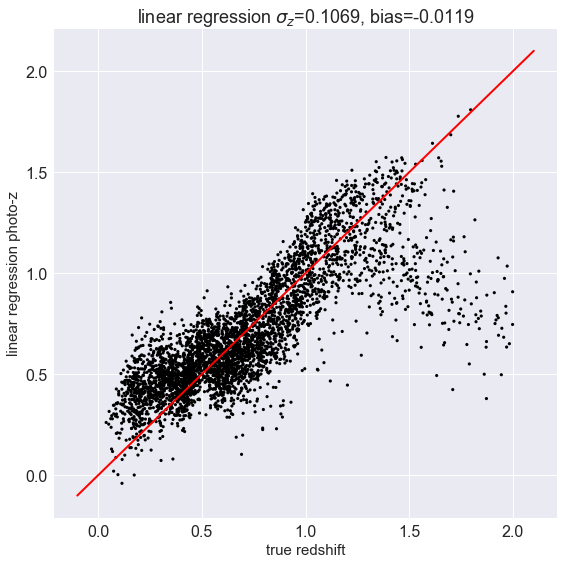

In [40]:
fig = plt.figure(figsize=(9,9))
plt.scatter(lsstobj.testzs,linreg2_pzs,s=10,c='k',edgecolor='none')
plt.plot([-.1,2.1],[-.1,2.1],c='r',lw=2)
plt.xlabel("true redshift",fontsize=15)
plt.ylabel("linear regression photo-z",fontsize=15)
titletext = "linear regression $\sigma_{z}$=%.4f, bias=%.4f"%(linreg2_sig,linreg2_bias)
plt.title(titletext,fontsize=18)

A bit worse with no regularization